<a href="https://colab.research.google.com/github/nolll77/jovian/blob/master/Image_Processing_Techniques_for_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Processing techniques for Computer Vision

Image Processing is an integral part of Computer vision. We almost always want to resize images, do data augmentation, see images in a grid, etc. OpenCV (Open source computer vision), scikit-image, Pillow are some popular image processing libraries in Python. In this article, I’ve covered some of the most commonly used Image processing techniques.

### Installing Open CV

In [0]:
!pip install opencv-python

### Library Imports

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.patches as patches
from pathlib import Path

## 1. Reading an Image

Images are represented as arrays consisting of pixel values. 8-bit images have pixel values ranging from 0 (black) to 255 (white). Depending on the color scale there are various [channels](https://en.wikipedia.org/wiki/Channel_%28digital_image%29) in an image, each channel representing the pixel values for one particular color. RGB (Red, green, blue) is the most commonly used color scale and all images I’ve used in my examples are RGB images.

We can easily read the image array using the imread function from OpenCV. One thing to remember here is that OpenCV reads images in BGR order by default.

Open-CV reads image in the BGR (Blue, Green, Red) order, so we change the order of channels to RGB

In [0]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

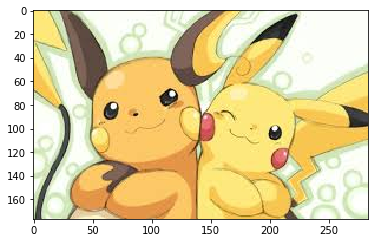

In [0]:
im = read_image('./pikachu_raichu.jpeg')
plt.imshow(im)

In [0]:
im.shape

(177, 284, 3)

## 2. Cropping an image

Cropping is a widely used augmentation technique. However, be careful as to not crop important parts of the image (pretty obvious, but easy to miss when you have too many images of various different sizes). Since images are represented using arrays, cropping is equivalent to taking out a slice from an array:

#### Center Crop 

In [0]:
def center_crop(im, crop_pixels = 50):
    return im[crop_pixels:im.shape[0] - crop_pixels, crop_pixels:im.shape[1] - crop_pixels]

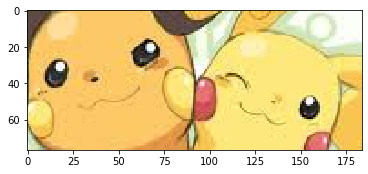

In [0]:
cropped = center_crop(im)
plt.imshow(cropped)

#### Random Crop

In [0]:
def random_crop(im, row_crop_pix = 20):
    rows, cols, _ = im.shape
    cols_crop_pix = round(row_crop_pix*cols/rows)
    row_crop_pix = int(np.floor(2*random.uniform(0, 1)*row_crop_pix))
    cols_crop_pix = int(np.floor(2*random.uniform(0, 1)*cols_crop_pix).astype(int))
    return im[row_crop_pix:rows - row_crop_pix, cols_crop_pix:cols - cols_crop_pix]

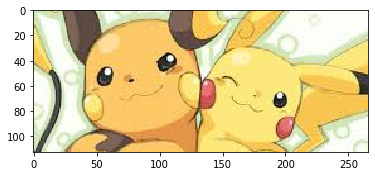

In [0]:
cropped = random_crop(im)
plt.imshow(cropped)

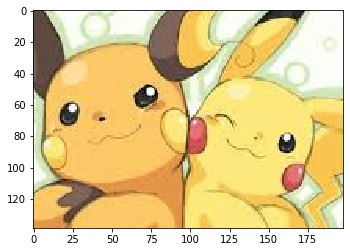

In [0]:
cropped = random_crop(im)
plt.imshow(cropped)

## 3. Resizing

Most deep learning model architectures expect all input images to be of the same dimensions.

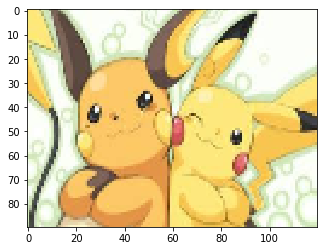

In [0]:
resized = cv2.resize(im, (120,90))
plt.imshow(resized)

## 4. Flip image

This is another very popular image augmentation technique. The only thing to remember here is that the flipping should make sense for your use case. For example, if you’re classifying building types, you wouldn’t encounter any inverted buildings in your test set so it doesn’t make sense to do a vertical flip in this case.

#### Vertical flip

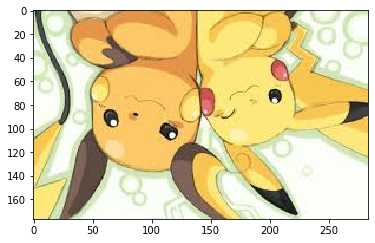

In [0]:
flip_v = np.flip(im,0)
plt.imshow(flip_v)

#### Horizontal flip

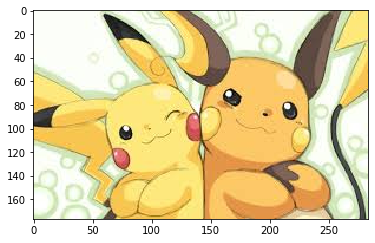

In [0]:
flip_h = np.flip(im,1)
plt.imshow(flip_h)

## 5. Rotate image

In most cases, it is okay to rotate the image by a small angle. The naive way of doing this might change the entire orientation of the image in some cases like in this case.

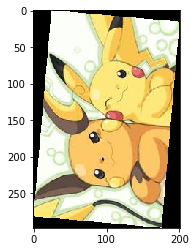

In [0]:
from scipy import ndimage
rotated = ndimage.rotate(im, 85)
plt.imshow(rotated)

#### Affine transformation with border filling

Hence, a better way of rotating is by doing an affine transform using OpenCV. An affine transformation preserves collinearity and ratios of distances (eg: the midpoint of a line segment continues to remain the midpoint even after transformation). You can also fill the borders by using the BORDER_REFLECT flag.

In [0]:
def affine_img(img, angle):
    rows, columns, _ = img.shape
    M = cv2.getRotationMatrix2D((rows/2,columns/2),angle,1) #Calculates an affine matrix of 2D rotation.
    return cv2.warpAffine(img,M,(columns,rows), borderMode=cv2.BORDER_REFLECT, 
                          flags=cv2.INTER_NEAREST)

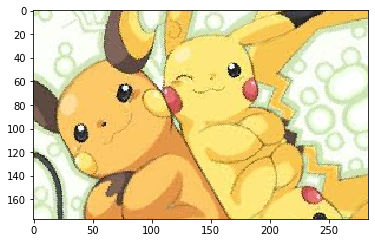

In [0]:
rotated = affine_img(im, 30)
plt.imshow(rotated)

## 6. Change Brightness and Contrast

This involves applying the following function to each pixel:

$g(x)=αf(x)+β$

Here alpha (>0) is called gain and beta is called bias, these parameters are said to control contrast and brightness respectively. Since we represent images using arrays, this function can be applied to each pixel by traversing through the array:

In [0]:
def bright_contrast_loop (image, alpha=1, beta=0):
    new_image = np.zeros(image.shape, image.dtype)
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            for c in range(image.shape[2]):
                new_image[y,x,c] = np.clip(alpha*image[y,x,c] + beta, 0, 255)
    return new_image

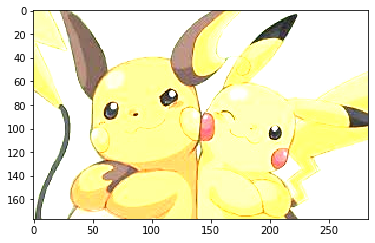

In [0]:
contrast_im = bright_contrast_loop(im,alpha=1.5)
plt.imshow(contrast_im)

### Changing brightness and contrast using library function

However, this could take a while on bigger images (like the one below), so you’d want to use the optimized library function.

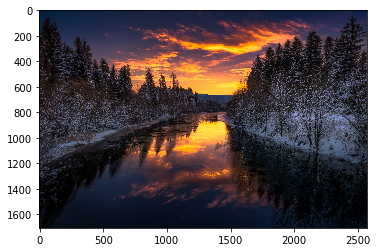

In [0]:
im = read_image('./landscape_img.jpg')
plt.imshow(im)

In [0]:
def bright_contrast (image, alpha=1, beta=0):
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

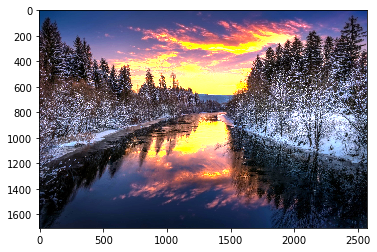

In [0]:
contrast_im = bright_contrast(im, alpha=2)
plt.imshow(contrast_im)

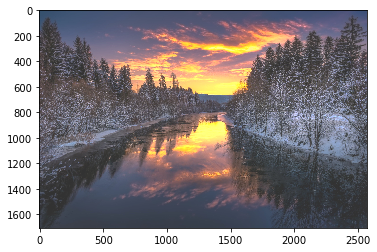

In [0]:
brighter_im = bright_contrast(im, beta=50)
plt.imshow(brighter_im)

## 7. Bounding Box

Object detection is a very popular computer vision problem that involves finding a bounding box enclosing the object of interest. Displaying the bounding box on the picture can help us visually inspect the problem and requirements. One thing to remember while dealing with these problems is that if you’re planning to flip the image, make sure you flip the box coordinates accordingly too. Here’s an easy way to display an image with its bounding box.

[Image source : Oxford-IIIT Pet Dataset ](https://www.robots.ox.ac.uk/~vgg/data/pets/)

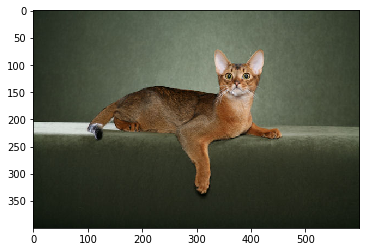

In [0]:
im = read_image('./cat_bb.jpg')
plt.imshow(im)

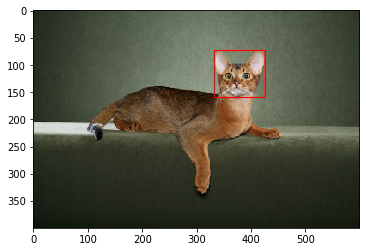

In [0]:
xmin = 333
ymin= 72
xmax = 425
ymax = 158

fig,ax = plt.subplots(1)
ax.imshow(im)
#make rectangular bounding box
bb = patches.Rectangle(xy=(xmin,ymin),width=xmax-xmin,height=ymax-ymin,linewidth=1.2,edgecolor='r',facecolor='none')
ax.add_patch(bb) #add bounding box to image
plt.show()

## 8. Showing multiple images in a grid

Often we want to inspect multiple images in one go. It can be easily done using subplots in matplotlib.

In [0]:
image_paths = list(Path('./dogs').iterdir()) 
images = [read_image(p) for p in image_paths]

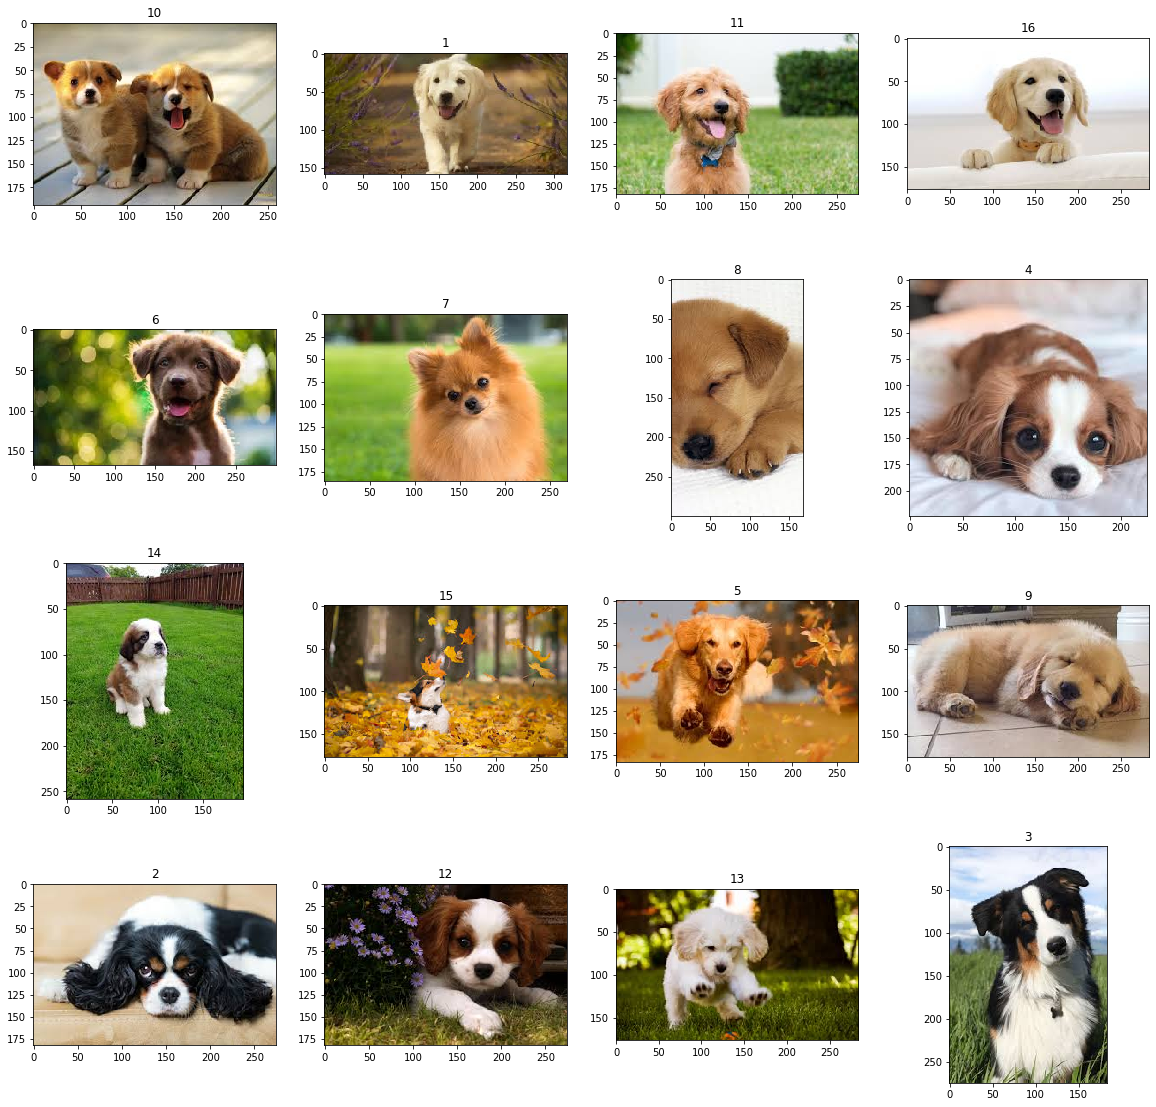

In [0]:
fig = plt.figure(figsize=(20, 20))
columns = 4
rows = 4

pics = []
for i in range(columns*rows):
    pics.append(fig.add_subplot(rows, columns, i+1,title=image_paths[i].parts[-1].split('.')[0]))
    plt.imshow(images[i])

plt.show() 

## 9. Convert to black and white

Although not widely used in computer vision, it’s nice to know how to convert color images to greyscale.

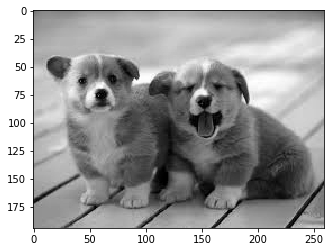

In [0]:
from skimage import color
from skimage import io

img = color.rgb2gray(io.imread(str(image_paths[0])))
plt.imshow(img,cmap = plt.cm.gray)

## 10. Blur

This technique can be useful in making your model more robust to image quality issues. If a model can perform well on blurred images, it may indicate the model is doing well in general.

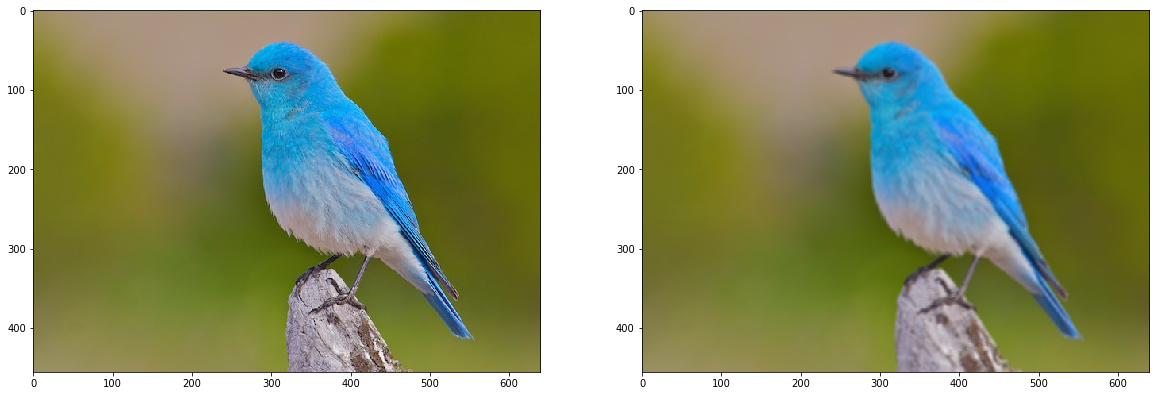

In [0]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

im = read_image('./bird.jpg')
blur = cv2.blur(im,(5,5))
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(im)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(blur)